# nuclei spotter

#### libs


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

In [212]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.morphology import label
import copy

In [5]:
import fastai
fastai.__version__

'1.0.52'

In [6]:
torch.cuda.is_available()

True

### look at the data

In [7]:
path = Path('/home/ubuntu/data/fastai/data/nuclei'); 
trn_path = path/'stage1_train'
path.ls()[:5]

[PosixPath('/home/ubuntu/data/fastai/data/nuclei/label'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_train_labels.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/final_submission_stage2.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage1_solution.csv'),
 PosixPath('/home/ubuntu/data/fastai/data/nuclei/test.png')]

In [8]:
stage1_train_labels = pd.read_csv(path/'stage1_train_labels.csv'); stage1_train_labels.head(2)

,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...


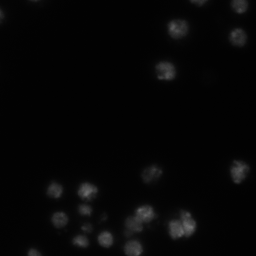

In [9]:
imgId, pixels = stage1_train_labels.iloc[0]
imgPath = path/f'stage1_train/{imgId}/images/{imgId}.png'
open_image(imgPath)

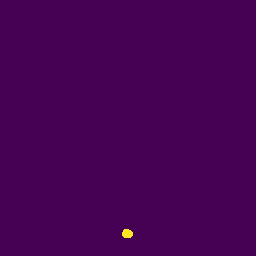

In [10]:
maskPath = path/f'stage1_train/{imgId}/masks'
open_mask(maskPath.ls()[0])

### concatenate masks into 1 file per image

1x image --> 1y mask

In [11]:
def image2np(path):
    x = plt.imread(str(path))
    a = np.asarray(x)
    return a.astype(np.float32, copy=False)
    
def combineMasks(imagePath):
    imgId = imagePath.stem
    imgPath = imagePath/f'images/{imgId}.png'
    imgSize = image2np(imgPath).shape
    all_masks = np.zeros(imgSize[:2])
    masksPath = imagePath.parent/f'{imgId}/masks'

    # add masks to one into 1 image
    for mask in masksPath.ls():
        currMask = image2np(mask)
#         currMask = np.expand_dims(currMask)

        all_masks = np.maximum(all_masks, currMask )
    return all_masks

In [12]:
img_fnames = [ img/f'images/{img.stem}.png' for img in trn_path.ls()]
img_folders = trn_path.ls()

In [13]:
curr_masks = [ [ mask for mask in (folder/'masks').ls()] for folder in img_folders ]

In [14]:
all_masks = reduce((lambda x,y: x + y), curr_masks)

In [15]:
np.amax(image2np(all_masks[0]))

1.0

In [16]:
combineMasks(img_folders[0])

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.],
       [0., 0., 0., 0., ..., 1., 1., 1., 1.]])

## move the images to a different folder

put all images at in base level folder 
images
all masks in label folder called labels

In [17]:
def saveArray(path, m):
    pil_image = PIL.Image.fromarray(m).convert("L")
    pil_image.save(path)

In [18]:
train_path = path/'train'
label_path = path/'label'

In [19]:
# copy all images to path/train
for img in tqdm(img_folders):
    imgPath = str(img/f'images/{img.stem}.png')
    newImgPath = str(train_path/f'{img.stem}.png')
#     print(imgPath)
#     print('--> ',newImgPath)
    if not (train_path/f'{img.stem}.png').is_file():
        !cp {imgPath} {newImgPath} 
    
    

100%|██████████| 670/670 [00:00<00:00, 32208.78it/s]


In [19]:
combined_masks = [{ 'name': img.stem,  'mask': combineMasks(img)} for img in img_folders];

In [20]:
# combine then copy all the masks to the train folder
for mask in combined_masks:
    
    maskPath = label_path/f'{mask["name"]}_mask.png'
    if not maskPath.is_file():
        saveArray(str(maskPath),mask["mask"])

NameError: name 'combined_masks' is not defined

In [21]:
new_masks = [ mask for mask in label_path.ls()]

In [22]:
mr = PIL.Image.open(str(new_masks[3]))
np.asarray(mr)

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)

In [23]:
image_shapes = [ x["mask"].shape[0] for x in combined_masks]
np.amin(image_shapes)

NameError: name 'combined_masks' is not defined

## Now make a databunch!

In [163]:
classes = np.array(["background", "nucleus"], dtype=str); classes

array(['background', 'nucleus'], dtype='<U10')

In [164]:
lng = len(train_path.ls())
valid_pct = int(lng*0.2)
valid_idx = list(range(lng))[:valid_pct]

get_y_fn = lambda x: label_path/f'{x.stem}_mask{x.suffix}'

In [165]:
src = (SegmentationItemList.from_folder(train_path) 
       .split_by_idx(valid_idx)
       .label_from_func(get_y_fn, classes=classes))

In [166]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10., 
                      max_zoom=1.1, 
                      max_lighting=0.2, 
                      max_warp=0., 
                      p_affine=0.75, 
                      p_lighting=0.75)
# tfms = get_transforms()

In [167]:
data64 = (src.transform(tfms, tfm_y=True, size=64)
       .databunch(bs=64))
# data = src.databunch()

In [168]:
data64.train_ds[4][1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 1, 1, 1]]])

# The model and learner!

In [179]:
def dice(input:Tensor, targs:Tensor, iou:bool=True)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return 2. * intersect / union
    else: return intersect / (union-intersect+1.0)

In [180]:
dice_iou = partial(dice, iou=True)

In [181]:
torch.cuda.is_available()

True

In [182]:
wd=1e-2

In [183]:
learn = unet_learner(data64, models.resnet34, metrics=dice_iou,  wd=wd)

## size=64

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


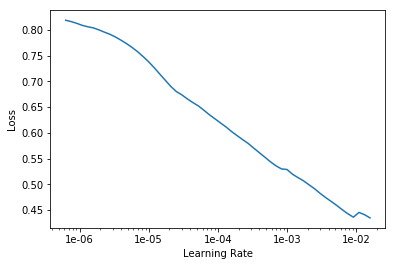

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,dice,time
0,0.515373,0.409782,0.000014,00:08
1,0.414285,0.377065,0.156388,00:06
2,0.333270,0.205942,0.565381,00:06
3,0.277085,0.152440,0.668503,00:06
4,0.238227,0.126046,0.697484,00:06
5,0.211730,0.115654,0.701212,00:06


In [43]:
learn = saveModel('nucleus-stage1-64', learn)

In [44]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


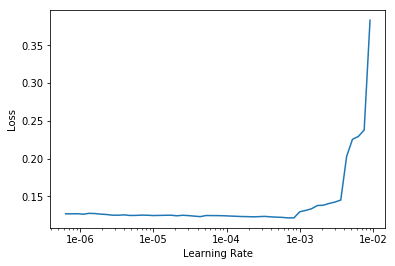

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(6, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.125189,0.115314,0.721381,00:06
1,0.124999,0.111074,0.728897,00:06
2,0.121881,0.107119,0.735350,00:06
3,0.119449,0.099894,0.746782,00:06
4,0.117401,0.098188,0.741339,00:06
5,0.115646,0.097995,0.741709,00:07


In [47]:
learn.save('nucleus-stage2-64')

In [48]:
learn = learn.load('nucleus-stage2-64')

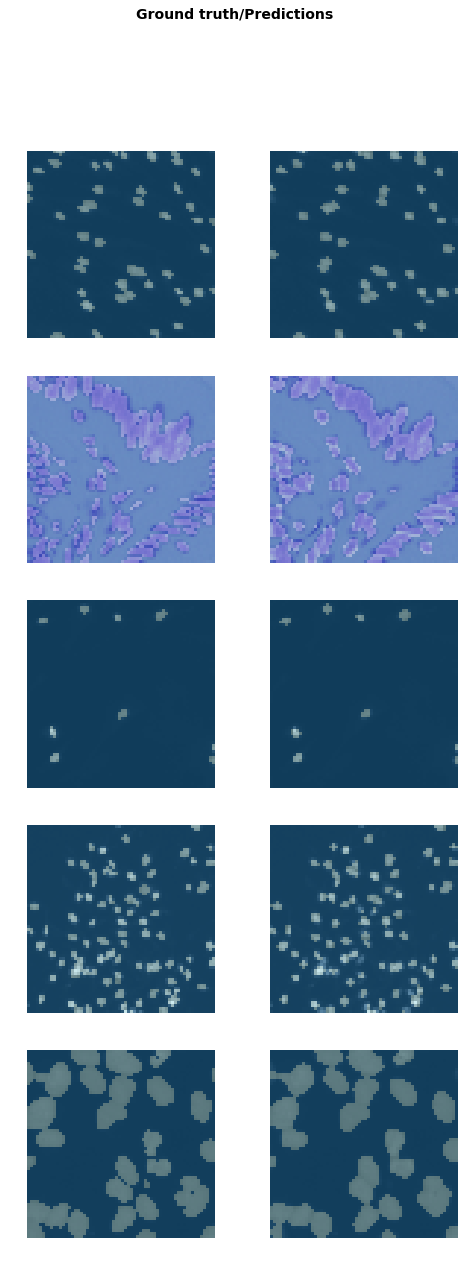

In [49]:
learn.show_results()

## size = 128

In [51]:
size = 128
data128 = (src.transform(tfms, tfm_y=True, size=size)
       .databunch(bs=64))

In [52]:
learn.data = data128

In [53]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


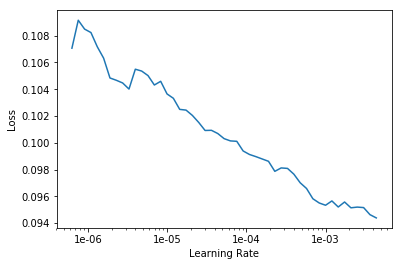

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(6, 1e-5)

epoch,train_loss,valid_loss,dice,time
0,0.102639,0.076579,0.796597,00:20
1,0.098130,0.077643,0.806246,00:17
2,0.095343,0.075967,0.809407,00:17
3,0.093132,0.073346,0.812512,00:17
4,0.091177,0.073103,0.812856,00:17
5,0.089908,0.073009,0.813111,00:17


In [56]:
learn.save('nucleus-stage1-128')

In [57]:
learn = learn.load('nucleus-stage1-128')

In [58]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


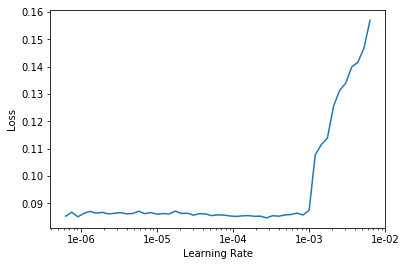

In [59]:
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.085644,0.071663,0.816536,00:17
1,0.085341,0.069879,0.822867,00:17
2,0.084529,0.069054,0.825325,00:17
3,0.082494,0.065966,0.829337,00:17
4,0.079957,0.068179,0.827131,00:17
5,0.078696,0.066863,0.830088,00:17


In [61]:
learn.save('nucleus-stage2-128')

In [62]:
learn = learn.load('nucleus-stage2-128')

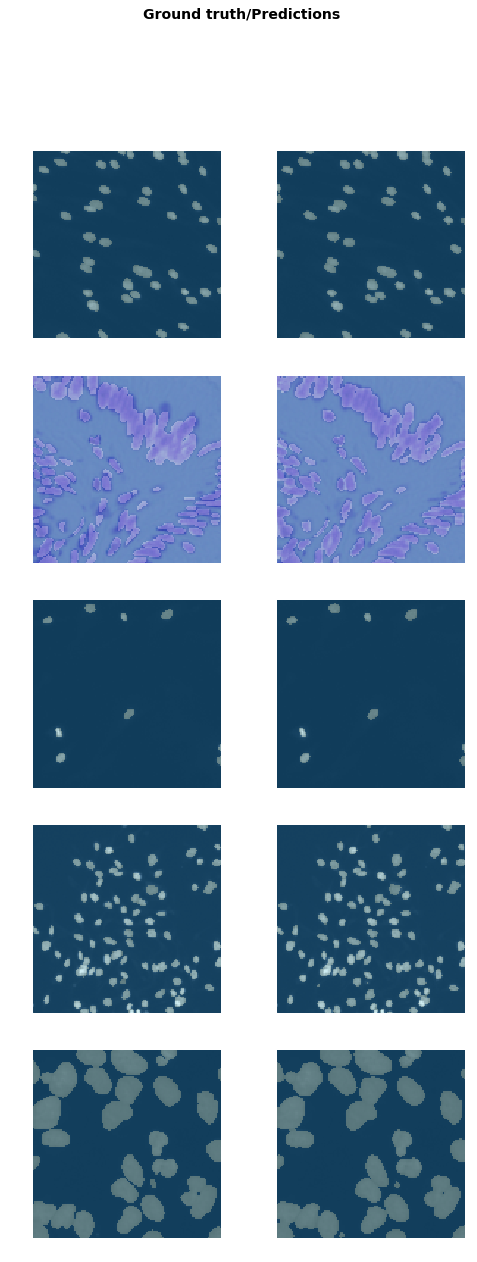

In [63]:
learn.show_results()

## size = 256

In [77]:
learn = learn.load('nucleus-stage2-128')

In [176]:
data256 = (src.transform(tfms, tfm_y=True, size=256)
       .databunch(bs=8))
learn.data = data256

In [57]:
learn = learn.to_fp16()

In [58]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


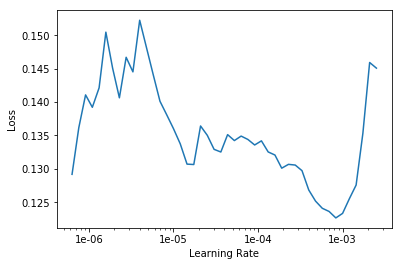

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lrs = slice(5e-5,6e-4)

In [61]:
learn.fit_one_cycle(6, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,0.100871,0.079148,0.788073,01:19
1,0.088171,0.068855,0.830570,01:18
2,0.084902,0.074616,0.812053,01:18
3,0.073679,0.056833,0.851413,01:18
4,0.067004,0.055610,0.857263,01:18
5,0.062095,0.055902,0.854534,01:18


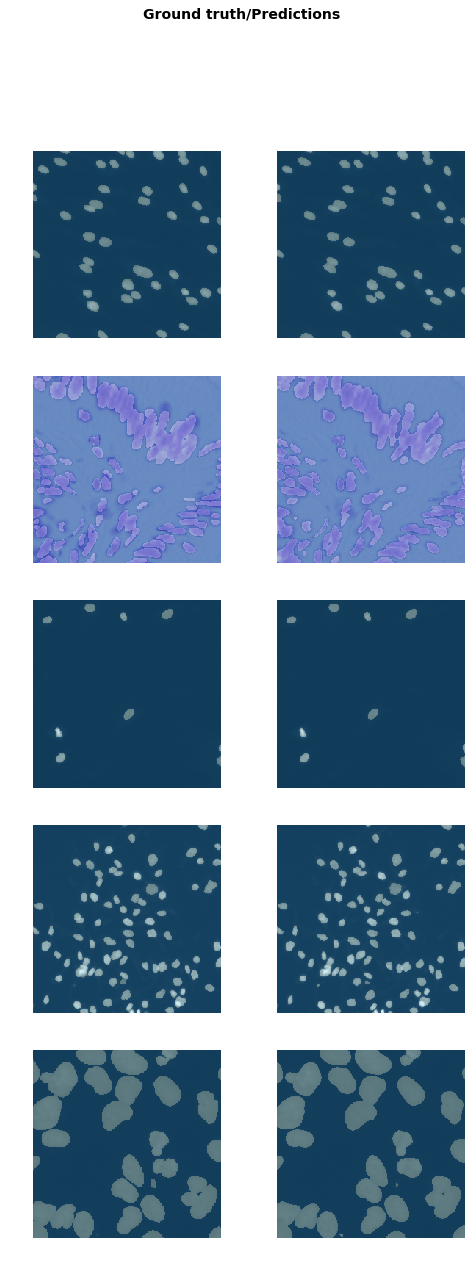

In [62]:
learn.show_results()

In [39]:
learn.unfreeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


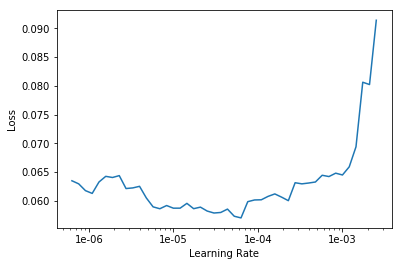

In [45]:
learn.recorder.plot()

In [47]:
learn.lr_find(start_lr=1e-9)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


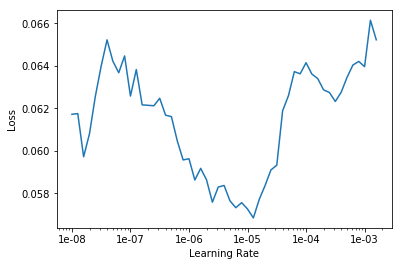

In [48]:
learn.recorder.plot()

In [49]:
lrs = slice(1e-7,1e-6)

In [50]:
learn.fit_one_cycle(2, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,0.062340,0.054986,0.859063,01:21
1,0.063473,0.055346,0.858364,01:21


In [51]:
learn.save('nucleus-stage2-256')

In [ ]:
learn = learn.load('nucleus-stage2-256')

In [52]:
learn.fit_one_cycle(5, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,0.060979,0.055099,0.858946,01:21
1,0.061046,0.054418,0.859187,01:21
2,0.062556,0.054540,0.858968,01:21
3,0.062650,0.054808,0.858975,01:21
4,0.059773,0.055845,0.857757,01:21


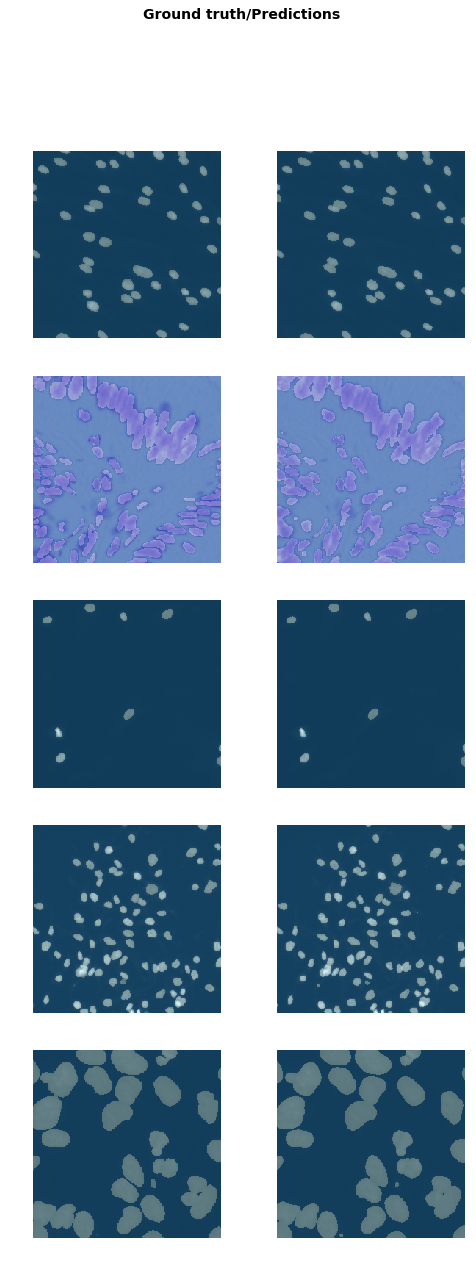

In [64]:
learn.show_results()

## size = 512 

In [34]:
learn = learn.load('nucleus-stage2-256')

In [74]:
data512 = (src.transform(tfms, tfm_y=True, size=512)
       .databunch(bs=4))
learn.data = data512

In [75]:
learn = learn.to_fp16()

In [76]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


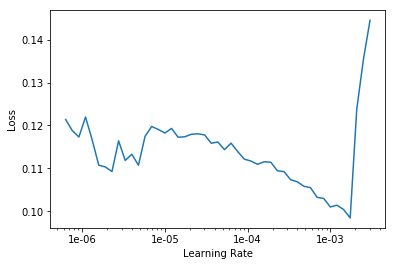

In [77]:
learn.lr_find()
learn.recorder.plot()

In [78]:
lrs = slice(5e-4,5e-3)

In [79]:
learn.fit_one_cycle(2, max_lr=lrs)

epoch,train_loss,valid_loss,dice,time
0,nan,nan,0.000000,05:04
1,nan,nan,0.000000,05:00


In [81]:
learn.show_results??

# Prediction

The model above resizes the input and output images for training.

To submit must predict each image in test set based on what size it is?

would it be possible to do this?

In [188]:
# load the images from file to a good looking ndarray(h x w x 3)
def imageRGB2np(path):
    img = PIL.Image.open(str(path))
    a = np.array(img)

    # normalize to 0 - 255 for channel
    if np.amax(a) > 255:
        a = a/(a.max()/255.0)

    # if only 1 channel then stack like a RGB image
    if len(a.shape) == 2:
        a = np.stack((a,)*3, axis=-1)

    # remove Alpha channel
    a = a[:,:,:3] 

    # convert to PIL and back becuause it seems to help
    newPIL = PIL.Image.fromarray(a.astype('uint8'))
    a = np.array(newPIL)
    a = a.astype(np.float32, copy=False)
    
    ## normalize to between 0 and 1
    a = a/255
    
    return a

In [189]:
learn = learn.load('nucleus-stage2-256')

In [190]:
data256 = (src.transform(tfms, tfm_y=True, size=256)
       .databunch(bs=8))
learn.data = data256

In [187]:
# learn = learn.to_fp32()

In [191]:
test1_path = path/'stage1_test'

In [139]:
test1_images_fnames = [ ({'imgId': i.stem, 'path':i/f'images/{i.stem}.png' }) for i in test1_path.ls()]
test1_x = [ imageRGB2np(x['path']) for x in test1_images_fnames ];
test1_x_sizes = [ x.shape[:2] for x in test1_x]; 

test1_x_sizes[0]

(512, 680)

In [140]:
test2_path = path/'stage2_test'

In [141]:
test2_images_fnames = [ ({'imgId': i.stem, 'path':i/f'images/{i.stem}.png' }) for i in test2_path.ls()]
test2_x = [ imageRGB2np(x['path']) for x in test2_images_fnames ];
test2_x_sizes = [ x.shape[:2] for x in test2_x]; 


In [142]:
test2_images_fnames.__len__()

3019

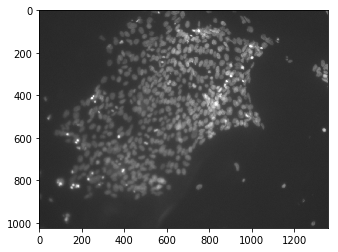

In [143]:
# check the bad data is loaded correctly
plt.imshow(test2_x[1367])

In [91]:
type(plt.imread(str(test2_images_fnames[1]["path"])))

numpy.ndarray

In [1]:

# testing this image
test_img_path = test2_images_fnames[0]["path"]


img = PIL.Image.open(str(test_img_path))
a = np.array(img)

# normalize to 0 - 255 for channel
if np.amax(a) > 255:
    a = a/(a.max()/255.0)

# if only 1 channel then stack like a RGB image
if len(a.shape) == 2:
    a = np.stack((a,)*3, axis=-1)

# remove Alpha channel
a = a[:,:,:3] 
# a = a.astype(np.float32, copy=False)


newPIL = PIL.Image.fromarray(a.astype('uint8'))

a = np.array(newPIL)

# plt.imshow(a)

inputImage(a)

NameError: name 'test2_images_fnames' is not defined

In [111]:
test2_images_fnames[0]["path"]

PosixPath('/home/ubuntu/data/fastai/data/nuclei/stage2_test/5390acefd575cf9b33413ddf6cbb9ce137ae07dc04616ba24c7b5fe476c827d2/images/5390acefd575cf9b33413ddf6cbb9ce137ae07dc04616ba24c7b5fe476c827d2.png')

In [118]:
img = PIL.Image.open(str(test2_images_fnames[0]["path"]))
np.array(img).shape

(531, 538, 4)

#### checkout the shapes of the images

In [156]:
def imgShape(path): return image2np(path).shape

In [157]:
test_img_shapes = [ imgShape(i['path']) for i in test_images_fnames ]; test_img_shapes[0]


(512, 680, 3)

In [158]:
sizes_test = [ i[:2] for i in test_img_shapes]; sizes_test[0]

(512, 680)

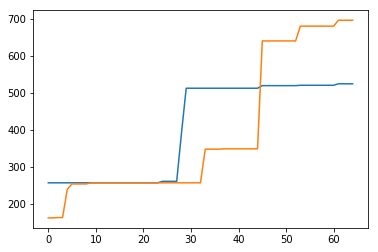

In [159]:
plt.plot(np.sort(sizes_test, axis=0))
plt.show()

### predition bit

We need to predict the mask for every image in test set

Each image in the test set is a different size.


x -> model.predict(x) --> y_hat vs y

need to resize the x input image down to 256
&&
upscale the output prediction mask to original size


In [147]:
import copy

mean = torch.FloatTensor(imagenet_stats[0])
std = torch.FloatTensor(imagenet_stats[1])

def inputImage(arr):
    x = torch.from_numpy(arr).transpose(2, 0).transpose(2,1)
    normalize(x ,mean, std )
    return vision.image.Image(x).resize(256)

def scaleUpOutput(ImageSegment, sizeTuple):
    imgCopy = copy.deepcopy(ImageSegment)
    imgCopy._px = imgCopy._px.float()
    imgCopy.resize((1, *sizeTuple))
    return imgCopy


In [192]:
testImageList = [ inputImage(i) for i in test1_x ]

In [193]:
# learn.data.single_dl.dataset.tfmargs['size'] = 256

In [271]:
xs = test1_x + test2_x
xs_sizes = test1_x_sizes + test2_x_sizes
test_ids = [ x["imgId"] for x in (test1_images_fnames + test2_images_fnames)]

# xs = test2_x
# xs_sizes = test2_x_sizes
# test_ids = [ x["imgId"] for x in test2_images_fnames]

testImageList = [ inputImage(i) for i in xs ]

test_preds = []
for x in tqdm(testImageList):
    pred = learn.predict(x)
    test_preds.append(pred)
# test_preds = [ learn.predict(x) for x in testImageList ]

test_preds_scaled = [ scaleUpOutput(x[0], y) for x, y in zip(test_preds, xs_sizes)]
test_preds_np = [ x.data.numpy() for x in test_preds_scaled]


100%|██████████| 3084/3084 [03:09<00:00, 15.50it/s]


#### scale up output images

In [221]:
# upsample the predicted masks!

img, y_pred, x = test_preds[0]
size_1 = test1_x_sizes[0]

print('input: ',img.data.shape, 'output: ', (1, *size_1))

def scaleUpOutput(ImageSegment, sizeTuple):
    imgCopy = copy.deepcopy(ImageSegment)
    imgCopy._px = imgCopy._px.float()
    imgCopy.resize((1, *sizeTuple))
    return imgCopy

# scaleUpOutput(img, size_1)    

input:  torch.Size([1, 256, 256]) output:  (1, 512, 680)


In [217]:
test_preds_scaled = [ scaleUpOutput(x[0], y) for x, y in zip(test_preds, test1_x_sizes)]

In [218]:
test_preds_np = [ x.data.numpy() for x in test_preds_scaled]

test_preds_np[0]

array([[[1, 1, 1, 1, ..., 0, 0, 0, 0],
        [1, 1, 1, 1, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 0, 0],
        [0, 0, 0, 0, ..., 0, 0, 1, 1],
        [0, 0, 0, 0, ..., 0, 0, 1, 1]]])

### RLE encoding and submission

In [272]:
get_mask = lambda x, i: (x == i).astype(np.int).squeeze() 

In [264]:
# check encoding on 1 image
lab_img = label(test_preds_np[0])

rles = []
for i in range(1, lab_img.max() + 1):
    mask =  get_mask(lab_img, i)
    if mask.sum() > 400:
        rles.append(rle_encode(mask))
rles.__len__()

36

In [274]:
final = []
thresh = 20

for arr, imgId in tqdm(zip(test_preds_np, test_ids)):
    
    rles = []
    lab_img = label(arr)
    
#     print(lab_img.max())
    for i in range(1, lab_img.max() + 1):
        mask =  get_mask(lab_img, i)
        if mask.sum() > thresh:
            rle_str = rle_encode(mask)
            final.append({'ImageId': imgId, 'EncodedPixels': rle_str})
    
    

3084it [02:04, 22.47it/s]


In [275]:
final.__len__()

107403

In [276]:
df = pd.DataFrame(final, columns=['ImageId','EncodedPixels']); df.head()

,ImageId,EncodedPixels
0,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,413 42 1093 42 1768 55 2448 55 3125 61 3805 61...
1,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,3389 5 4069 5 4735 22 5415 22 6085 32 6765 32 ...
2,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,4083 13 4763 13 5441 26 5477 8 6121 26 6157 8 ...
3,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,12759 11 13439 11 14119 19 14799 19 15474 27 1...
4,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,30525 2 31205 2 31882 8 32562 8 33239 14 33919...


In [278]:
df.to_csv(path/'submission_stage1+2_unet_256_v1_rlethresh_20.csv', index=False)

In [324]:
all_ids = df["ImageId"].sort_values().unique()
len(all_ids)

65

In [289]:
sample_ids = pd.read_csv(path/'stage1_sample_submission.csv')["ImageId"].sort_values().unique()

In [279]:
1+1

2

In [280]:




S

NameError: name 'S' is not defined

In [ ]:
SSS